<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Notebook-setup" data-toc-modified-id="Notebook-setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Notebook setup</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Functions</a></span><ul class="toc-item"><li><span><a href="#Functions-for-plotting-distribution-of-losses-across-chromosomes" data-toc-modified-id="Functions-for-plotting-distribution-of-losses-across-chromosomes-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Functions for plotting distribution of losses across chromosomes</a></span></li><li><span><a href="#Functions-for-plotting-change-in-fitness-and-mutation-rate-with-loss-length" data-toc-modified-id="Functions-for-plotting-change-in-fitness-and-mutation-rate-with-loss-length-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Functions for plotting change in fitness and mutation rate with loss length</a></span></li></ul></li><li><span><a href="#Import-data" data-toc-modified-id="Import-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Import data</a></span><ul class="toc-item"><li><span><a href="#UK-Biobank-mCA-calls" data-toc-modified-id="UK-Biobank-mCA-calls-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>UK Biobank mCA calls</a></span></li><li><span><a href="#Possible-significant-genes-involved-by-each-mCA" data-toc-modified-id="Possible-significant-genes-involved-by-each-mCA-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Possible significant genes involved by each mCA</a></span></li></ul></li><li><span><a href="#Checking-mCAs-with-high-cell-fractions" data-toc-modified-id="Checking-mCAs-with-high-cell-fractions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Checking mCAs with high cell fractions</a></span><ul class="toc-item"><li><span><a href="#Inferred-s-and-mu-values" data-toc-modified-id="Inferred-s-and-mu-values-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Inferred s and mu values</a></span></li></ul></li><li><span><a href="#Distribution-of-losses-around-key-genes" data-toc-modified-id="Distribution-of-losses-around-key-genes-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Distribution of losses around key genes</a></span></li><li><span><a href="#Length-dependence-of-fitness-effects-and-mutation-rates" data-toc-modified-id="Length-dependence-of-fitness-effects-and-mutation-rates-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Length dependence of fitness effects and mutation rates</a></span></li></ul></div>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# Notebook setup

In [2]:
# imported packages
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import MultipleLocator
import csv
import pandas as pd
import zipfile
from io import TextIOWrapper
import scipy
import scipy.special
from scipy import integrate
from scipy.integrate import quad
from scipy.interpolate import interp1d
import numpy as np

In [3]:
plt.style.use('cwpython.mplstyle') #use custom style file

In [4]:
#define the colors from colorbrewer2
orange1 = '#feedde'
orange2 = '#fdbe85'
orange3 = '#fd8d3c'
orange4 = '#e6550d'
orange5 = '#a63603'
blue1 = '#eff3ff'
blue2 = '#bdd7e7'
blue3 = '#6baed6'
blue4 = '#3182bd'
blue5 = '#08519c'
green1 = '#edf8e9'
green2 = '#bae4b3'
green3 = '#74c476'
green4 = '#31a354'
green5 = '#006d2c'
grey1 = '#f7f7f7'
grey2 = '#cccccc'
grey3 = '#969696'
grey4 = '#636363'
grey5 = '#252525'
purple1 = '#f2f0f7'
purple2 = '#cbc9e2'
purple3 = '#9e9ac8'
purple4 = '#756bb1'
purple5 = '#54278f'
red1 = '#fee5d9'
red2 = '#fcae91'
red3 = '#fb6a4a'
red4 = '#de2d26'
red5 = '#a50f15'

In [5]:
loss_color = '#a6cee3'
loss2_color = '#1f78b4'
loss_text = '#1f78b4'

In [6]:
color_type_dict = {'c_gain': '#e31a1c', 'b_neutral': '#fdbf6f', 'a_loss': '#a6cee3'}

# Functions

## Functions for plotting distribution of losses across chromosomes

In [7]:
def ideograms(ideogram_file, chromosome):
    
    color_lookup = {'gneg': (1., 1., 1.),
                    'gpos25': (.6, .6, .6),
                    'gpos50': (.4, .4, .4),
                    'gpos75': (.2, .2, .2),
                   'gpos100': (0., 0., 0.),
                      'acen': (.8, .4, .4),
                      'gvar': (.8, .8, .8),
                     'stalk': (.9, .9, .9)}
    
    ideogram = open(ideogram_file)
    ideogram.readline()
    xranges = []
    colors = []
    mid_points = []
    labels = []

    for line in ideogram:
        chrom, start, stop, label, stain = line.strip().split('\t')
        start = int(start)
        stop = int(stop)
        width = stop - start
        mid_point = start + (width/2)
        if chrom == chromosome:
            xranges.append((start, width))
            colors.append(color_lookup[stain])
            mid_points.append(mid_point)
            labels.append(label)
        
    return xranges, [0, 0.9], colors, mid_points, labels

In [8]:
def plot_gene(gene_midpoint, gene_name, association, y_val, ax):
    if association == 'CNLOH':
        color_choice = neutral_line
        text_color = neutral_text
    if association == 'Loss':
        color_choice = loss2_color
        text_color = loss_text
    if association == 'Gain':
        color_choice = gain_color
        text_color = gain_text
    ax.plot([gene_midpoint, gene_midpoint], [0, y_val+1], linestyle = ':', lw = 1.5, color = color_choice)
    ax.text(gene_midpoint, (y_val+1)*1.02, gene_name, ha = 'left', fontsize = 10, color = text_color, style='italic', fontweight = 'bold', rotation = 45)
    return ax

In [9]:
def plot_gene_CH(gene_midpoint, gene_name, y_val, ax):
    ax.plot([gene_midpoint, gene_midpoint], [0, y_val+1], linestyle = ':', lw = 1.5, color = grey3)
    ax.text(gene_midpoint, (y_val+1)*1.02, gene_name, ha = 'left', fontsize = 10, color = grey3, style='italic', rotation = 45)
    return ax

In [10]:
def plot_region(gene_midpoint, gene_name, association, y_val, ax):
    if association == 'CNLOH':
        color_choice = neutral_line
        text_color = neutral_text
    if association == 'Loss':
        color_choice = loss2_color
        text_color = loss_text
    if association == 'Gain':
        color_choice = gain_color
        text_color = gain_text
    ax.plot([gene_midpoint, gene_midpoint], [0, y_val+1], linestyle = ':', lw = 1.5, color = color_choice)
    ax.text(gene_midpoint, (y_val+1)*1.02, gene_name, ha = 'center', fontsize = 10, color = text_color, style='italic')
    return ax

In [11]:
def shade_deletion(start, stop, name, y_val, ax):
    ax.fill_between([start, stop], [0, 0], [y_val+1, y_val+1], facecolor="none", hatch="//////", edgecolor=grey2, linewidth=0.0, alpha = 0.5)
    ax.fill_between([start, stop], [0, 0], [y_val+1, y_val+1], color='white', linewidth=0.0, alpha = 0.4)  
    ax.text(((stop+start)/2), (y_val+1)*1.02, name, ha = 'center', fontsize = 10, color = loss_text, style='italic')
    return ax

In [12]:
def distribution_losses(chromosome, genes_involved, total_mCAs):
    plt.close('all')
    gs_kw = dict(width_ratios=[1], height_ratios=[4, 1])
    fig, axes = plt.subplots(figsize=(15, 3), nrows=2, ncols=1, gridspec_kw=gs_kw)
    fig.subplots_adjust(hspace=0.02, wspace = 0.02)

    ax1 = axes[0]
    ax2 = axes[1]

    # Plot data
    positions = []
    for k, v in CNV_dict.items():
        type_of_change = v[5]
        total_mCAs_per_person = v[10]
        if type_of_change == 'loss':
            type_of_change = 'a_loss'
            if v[1] == chromosome:
                start = int((v[2])*1000000)
                end = int((v[3])*1000000)
                width = end-start
                if total_mCAs == 'all':
                    positions.append((start, end, width, type_of_change))
                else:
                    if total_mCAs_per_person == total_mCAs:
                        positions.append((start, end, width, type_of_change))

    positions.sort(key = lambda x: (x[3], x[2]), reverse = True) #sort the positions list by width (with widest change first)

    sorted_positions = []
    
    y_val = 0
    
    for i in positions: #iterate through the width sorted list and add 1 to the y for each mCA (as width decreases)
        start = i[0]
        end = i[1]
        width = i[2]
        color_type = color_type_dict[i[3]]
        sorted_positions.append((start, end, width, y_val, color_type))
        y_val+=1

    for i in sorted_positions: #iterate through the sorted list
        y_value = i[3]
        color_type = i[4]
        ax1.plot([i[0], i[1]], [y_value, y_value], color = color_type, lw = 2)
        
    ###### PLOT GENES ######    
    genes_possibly_involved = genes_involved[chromosome]
    for i in genes_possibly_involved:
        gene_name = i[0]
        midpoint = i[1]
        effect = i[2]
        if (effect != '') and (effect in ['Loss']):
            plot_gene(midpoint, gene_name, effect, y_val, ax1)
        else:
            plot_gene_CH(midpoint, gene_name, y_val, ax1)
        
    if chromosome == 'chr14':
        shade_deletion(106032614, 107288051, 'IGH locus', y_val, ax1) #IGH locus
        
    if chromosome == 'chr22':
        plot_region(22600000, 'IGL locus (22q11.2)', 'Loss', y_val, ax1)        

    ##### Plot chromosome #####
    xranges, yrange, colors, midpoints, labels = ideograms('Data_files/Chromosome_ideogram_hg19.txt', chromosome)

    ax2.broken_barh(xranges, yrange, facecolors= colors, edgecolor = 'black')

    end_chromosome = xranges[-1][0]+xranges[-1][1]+1000000

    ax1.set_xticks([])
    ax1.set_xlim(0, end_chromosome)
    ax2.set_xlim(0, end_chromosome)
    
    ax1.set_ylim(0, y_val+10)

    ax2.set_xticks(midpoints)
    ax2.set_xticklabels(labels, rotation = 90, fontsize = 9)
    ax2.set_yticks([])
    ax2.text(-0.06, 0.35, chromosome, transform=ax2.transAxes, fontsize = 14, fontweight = 'bold')
    ax2.text(1.005, 0.35, str(int(end_chromosome/1000000))+' MB', transform=ax2.transAxes, fontsize = 10, fontweight = 'bold', ha = 'left')

    ax1.yaxis.set_tick_params(width=1.0, color = grey3, length = 6)
    ax2.xaxis.set_tick_params(width=0.8, color = grey3, length = 6)

    ax1.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    
    ax1.set_ylabel('mCA number')

    plt.minorticks_off()
    plt.tight_layout()
#     plt.savefig('Figures/Distribution_of_mCAs_across_chromosomes/Length_dependence_losses_'+str(chromosome)+'_total_1_mCA_per_person.pdf')
    
    return plt.show()

## Functions for plotting change in fitness and mutation rate with loss length

In [66]:
def change_s_mu_length_plot(gene_or_region_of_interest, s_mu_length_dependence_dict, s_min, s_max, mu_min, mu_max):

    s_dict = {}
    mu_dict = {}
    
    s_CI_dict = {}
    mu_CI_dict = {}
    
    s_lower_error = []
    s_upper_error = []
    
    mu_lower_error = []
    mu_upper_error = []
    
    x1 = []
    y1 = []
    
    x2 = []
    y2 = []
    
    labels = []

    for k, v in s_mu_length_dependence_dict.items(): #e.g. k = 'ASXL1_30-100MB'
        gene_or_region = k.split('_')[0]
        if gene_or_region == gene_or_region_of_interest:
            s = v['s']*100
            lower_s = v['lower_95_s']*100
            upper_s = v['upper_95_s']*100
            low_s = s-lower_s
            high_s = upper_s-s

            mu = v['mu']
            lower_mu = v['lower_95_mu']
            upper_mu = v['upper_95_mu']
            low_mu = mu-lower_mu
            high_mu = upper_mu-mu

            interval = k.split('_')[1].split('MB')[0] #e.g. '30-100'
            if interval == '0-3':
                interval_point = 1.5
                labels.append('0-3 MB')
            if interval == '3-10':
                interval_point = 6.5
                labels.append('3-10 MB')
            if interval == '10-30':
                interval_point = 20
                labels.append('10-30 MB')
            if interval == '30-100':
                interval_point = 65
                labels.append('30-100 MB')
            if interval == '100-300':
                interval_point = 200
                labels.append('100-300 MB')

            x1.append(interval_point)
            y1.append(s)
            s_lower_error.append(low_s)
            s_upper_error.append(high_s)

            x2.append(interval_point)
            y2.append(mu)
            mu_lower_error.append(low_mu)
            mu_upper_error.append(high_mu)
        
    s_errors = [tuple(s_lower_error), tuple(s_upper_error)]            
    mu_errors = [tuple(mu_lower_error), tuple(mu_upper_error)]
        
    ###### CREATE THE SUBPLOTS #########
    fig, axes = plt.subplots(figsize=(14, 5), nrows=1, ncols=2)
    fig.subplots_adjust(hspace=0.3, wspace = 0.3)
    
    ax1 = axes[0]
    ax2 = axes[1]

    ## Plot the data ###    
    m_width = 1.5
    c_size = 3
    c_thick = 1.5
    e_width = 1.5
    
    color = loss_color
    integral_limit = 0.67
    
    ax1.errorbar(x1, y1, yerr = s_errors, capsize = 8, elinewidth = 2.5, capthick = 2.5)
    ax2.errorbar(x2, y2, yerr = mu_errors, capsize = 8, elinewidth = 2.5, capthick = 2.5)

    ax1.scatter(x1, y1, color = color, lw = 1, s = 200, zorder = 50, edgecolor = 'k')
    ax1.plot(x1, y1, color = color, lw = 2)
    
    ax2.scatter(x2, y2, color = color, lw = 1, s = 200, zorder = 50, edgecolor = 'k')
    ax2.plot(x2, y2, color = color, lw = 2)
    
    ax1.set_ylabel('fitness effect (% per year)', fontsize = 16)
    ax2.set_ylabel('mutation rate (per cell per year)', fontsize = 16)
    
    for ax in [ax1, ax2]:
        ax.set_xlim(0.7, 100)
        ax.set_xscale('log')
        ax.set_xlabel('length of loss (MB)', fontsize = 16)
        ax.tick_params(axis='y', which='major', labelsize=16)
        ax.tick_params(axis='x', which='major', labelsize=16)
    
    ax2.set_yscale('log')
    ax2.set_ylim(mu_min, mu_max)
        
    ax1.grid(which = 'both', axis = 'y')
    ax2.grid(which = 'both', axis = 'y')
    
    ax1.set_ylim(s_min, s_max)
    ax1.yaxis.set_major_locator(ticker.MultipleLocator(5))
    
    for x, y, label in zip(x1, y1, labels):
        ax1.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-50), # distance from text to points (x,y)
                     ha='center',
                     bbox=dict(boxstyle="round", fc="w", ec=grey4, lw=1), fontsize = 14) # horizontal alignment can be left, right or center
        
    for x, y, label in zip(x2, y2, labels):
        ax2.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-50), # distance from text to points (x,y)
                     ha='center',
                     bbox=dict(boxstyle="round", fc="w", ec=grey4, lw=1), fontsize = 14) # horizontal alignment can be left, right or center
        
    ax1.set_title(gene_or_region_of_interest+':  change in fitness with loss length', fontsize = 16, y = 1.05)
    ax2.set_title(gene_or_region_of_interest+':  change in mutation rate with loss length', fontsize = 16, y = 1.05)
    
    plt.tight_layout()
    plt.savefig('Figures/Loss_around_'+gene_or_region_of_interest+'_change_in_s_and_mu_with_length.pdf')
    
    return plt.show()

# Import data

## UK Biobank mCA calls

In [14]:
# create a dictionary from annotated mCA calls
with zipfile.ZipFile('Data_files/Supplementary_data_annotated_cw.csv.zip') as zf:
    with zf.open('Supplementary_data_annotated_cw.csv', 'r') as infile:
        read_reader = csv.reader(TextIOWrapper(infile, 'utf-8'))  #csv.reader returns a reader object which will iterate over lines in the csvfile
        row_count = 0
        CNV_dict = {}

        for row in read_reader:
            if row_count>0:
                ID = int(row[1])
                sex = row[2]
                age = row[3]
                prev_cancer = int(row[4])
                chrom = 'chr'+(row[5])
                start_mb = float(row[6])
                end_mb = float(row[7])
                size_mb = float(row[8])
                copy_change = row[11]
                cell_frac = row[12]
                total_mCAs = int(row[22])
                if cell_frac != 'unknown':
                    CNV_dict[row_count]=(float(cell_frac), chrom, start_mb, end_mb, size_mb, copy_change, ID, sex, age, prev_cancer, total_mCAs)

            row_count += 1

## Possible significant genes involved by each mCA

In [15]:
# create a dictionary of gene names with which to annotate the chromosomes
genes_involved_per_chromosome = {}

genes_involved_table = ('Data_files/Possible_genes_involved.csv')
with open(genes_involved_table, encoding = "ISO-8859-1") as table:
    reader = csv.reader(table)
    row_count=0
    for row in reader:
        if row_count>0:
            chromosome = row[0]
            gene = row[1]
            gene_or_region = row[2]
            effect = row[3]
            if gene_or_region == 'Gene':
                start = int(row[5])
                end = int(row[6])
                mid_point = (end+start)/2
                if 'chr'+chromosome in genes_involved_per_chromosome.keys():
                    genes_involved_per_chromosome['chr'+chromosome].append((gene, mid_point, effect))
                else:
                    genes_involved_per_chromosome['chr'+chromosome]=[(gene, mid_point, effect)]
       
        row_count+=1

# Checking mCAs with high cell fractions

In [16]:
def filter_by_number_mCAs(number_mCAs, dataframe): #e.g. filter by those that only have 1 total mCA
    mask = dataframe['total_mCAs']==number_mCAs
    return dataframe[mask].copy()

In [17]:
def filter_by_mCA_type(mCA_type, dataframe): #filter to only include those that have gains
    mask = [(mCA_type in x) for x in dataframe['COPY_CHANGE']]
    return dataframe[mask].copy()

In [18]:
zf = zipfile.ZipFile('Data_files/Supplementary_data_annotated_cw.csv.zip')
df_biobank = pd.read_csv(zf.open('Supplementary_data_annotated_cw.csv'))

In [19]:
def dataframe_df(band, mCA_type, df):
    df_mCA_type = filter_by_mCA_type(mCA_type, df) #filter to just include losses
    single_df = filter_by_number_mCAs(1, df_mCA_type) #filter to just include people that have just 1 mCA
    bands_df = single_df[single_df['bands_involved'].apply(lambda x: band in x)] #filters to only include 1 losses that involve the band of interest

    return bands_df

In [20]:
def dataframe_df(gene, mCA_type, df):
    df_mCA_type = filter_by_mCA_type(mCA_type, df) #filter to just include losses
    single_df = filter_by_number_mCAs(1, df_mCA_type) #filter to just include people that have just 1 mCA
    genes_df = single_df[single_df['genes_involved'].apply(lambda x: gene in x)] #filters to only include 1 losses that involve the gene of interest

    return genes_df

In [21]:
def log_logit_CFs(gene, df, lower_length, upper_length): #log and logit cell fractions

    df_CFs_mCA_upper = df[df['SIZE_MB'] < float(upper_length)]
    df_CFs_mCA_lower = df_CFs_mCA_upper[df_CFs_mCA_upper['SIZE_MB'] >= float(lower_length)]
    CFs_mCA = df_CFs_mCA_lower['CELL_FRAC'].to_list()

    logCFs = []
    logitCFs = []

    for i in CFs_mCA:
        logitCFs.append(scipy.special.logit(float(i)))
        logCFs.append(np.log(float(i)))

#     print('total '+gene+' mCAs length interval '+str(lower_length)+'-'+str(upper_length)+' = '+str(len(logitCFs)))
    return logCFs, logitCFs

In [22]:
s_mu_length_dependence = pd.read_csv('Data_files/mCA_s_mu_with_confidence_intervals_length_dependence_mCAs.txt', sep = '\t')
mCAs = s_mu_length_dependence['mCA'].to_list()

In [23]:
mCAs[:4]

['14q32.33_0-3MB', '14q32.33_30-100MB', '22q11.22_0-3MB', '22q11.22_10-30MB']

In [24]:
# Checking which have cell fractions >0.5:
for i in mCAs[:4]:
    gene = i.split('_')[0]
    lower_length = float(i.split('_')[1].split('-')[0])
    upper_length = float(i.split('_')[1].split('-')[1].split('M')[0])
    df = dataframe_df(gene, 'loss', df_biobank)
    logCFs, logitCFs = log_logit_CFs(gene, df, lower_length, upper_length)
    
    total = 0
    for cell_frac in logitCFs:
        if np.exp(cell_frac) >=1.0:
            total+=1
            
    if total>0:
        print(i)

## Inferred s and mu values

- Fitness and mutation rates inferred using mCA_mu_and_s_MLE_using_heatmaps_length_dependence_genes.py and mCA_mu_and_s_MLE_using_heatmaps_length_dependence_chromosomal_bands.py

In [46]:
#s and mu values inferred from MLE for different lengths of loss around certain regions/ genes
s_mu_length_dependence = pd.read_csv('Data_files/mCA_s_mu_with_confidence_intervals_length_dependence_mCAs.txt', sep = '\t')
s_mu_length_dependence = s_mu_length_dependence.set_index('mCA')
s_mu_length_dependence_dict = pd.DataFrame.to_dict(s_mu_length_dependence, orient = 'index')

# Distribution of losses around key genes

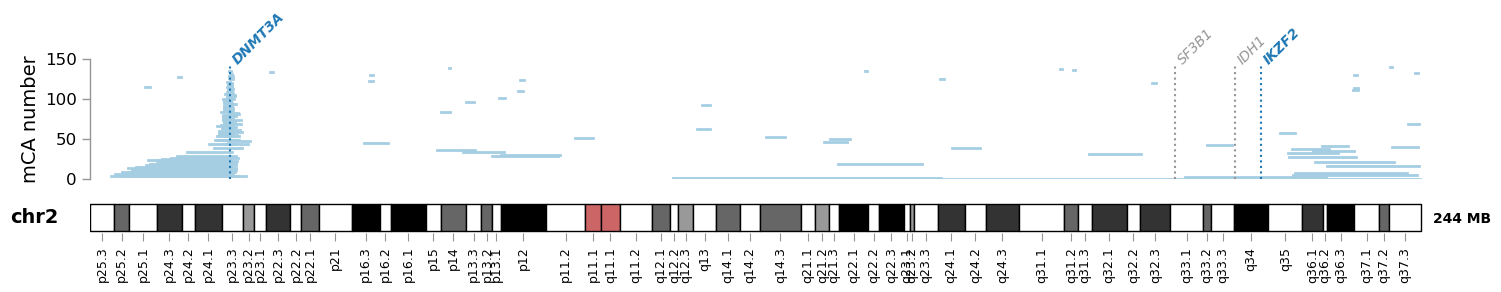

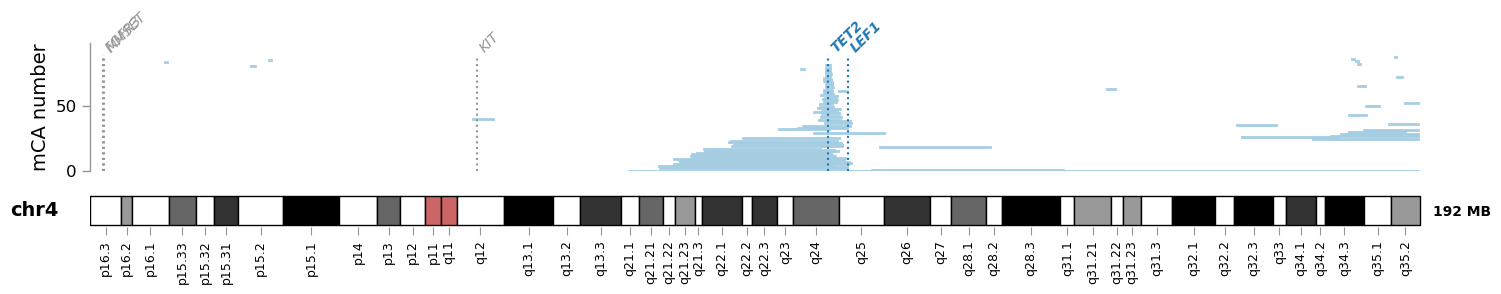

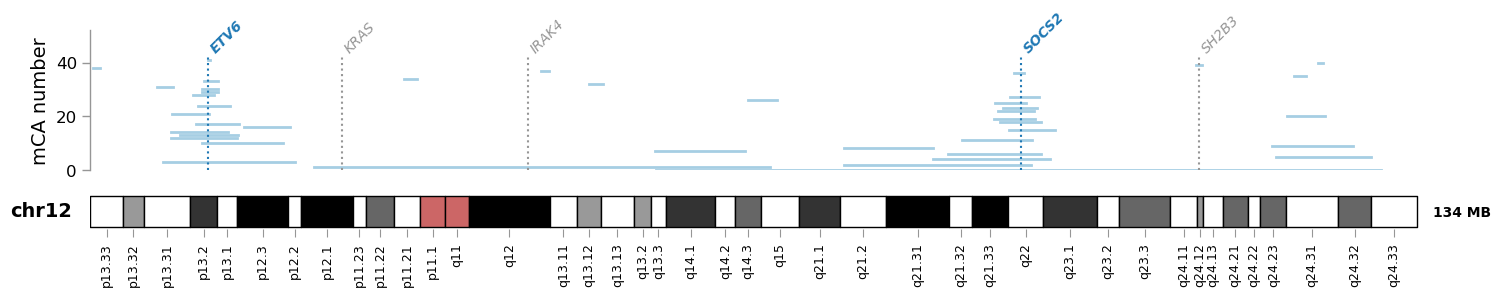

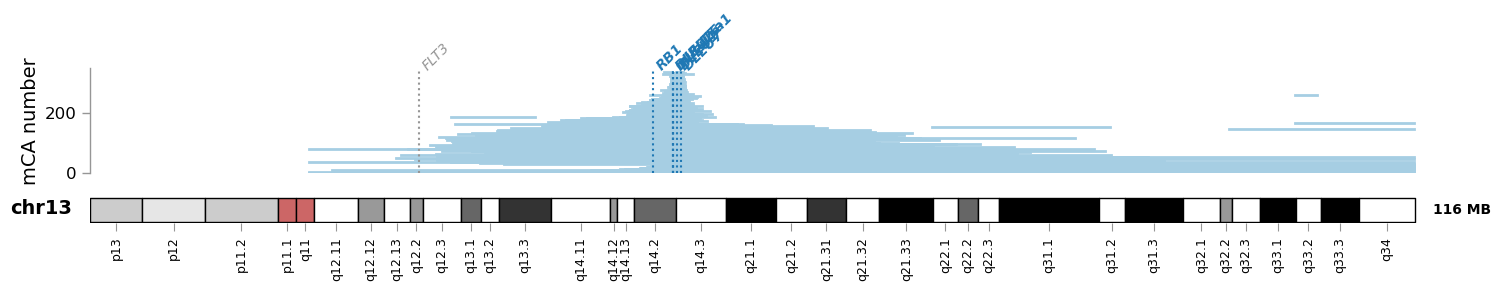

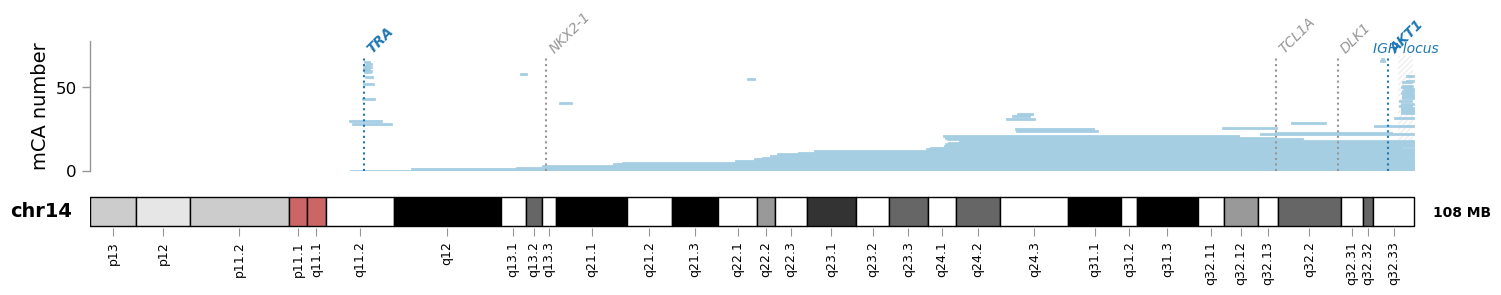

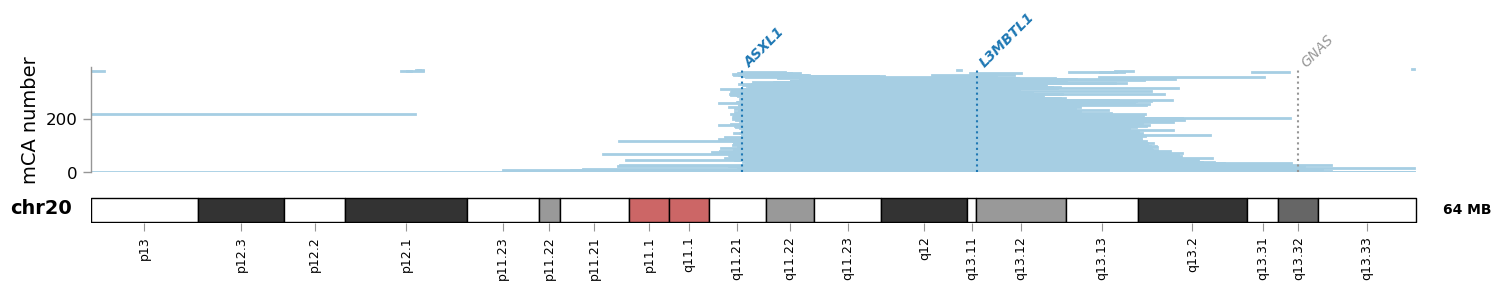

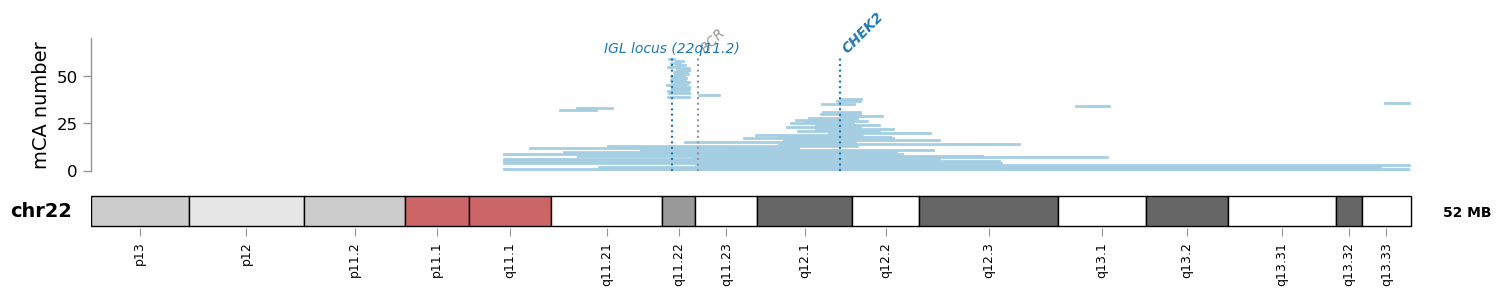

In [26]:
for i in ['chr2', 'chr4', 'chr12', 'chr13', 'chr14', 'chr20', 'chr22']:
    distribution_losses(i, genes_involved_per_chromosome, 1)

# Length dependence of fitness effects and mutation rates

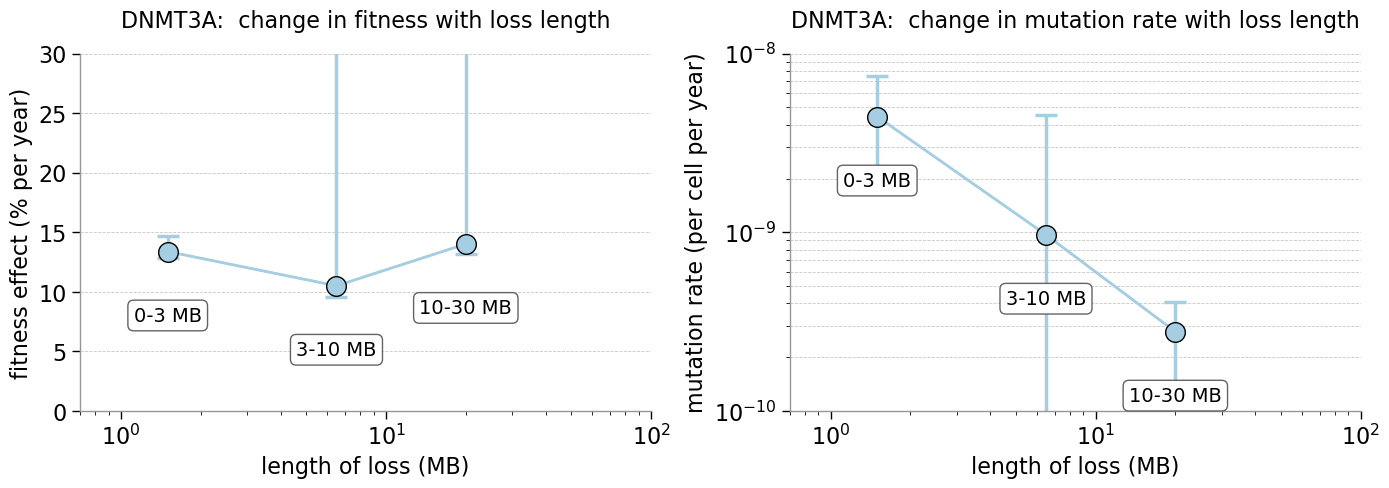

In [67]:
change_s_mu_length_plot('DNMT3A', s_mu_length_dependence_dict, 0, 30, 1e-10, 1e-8)

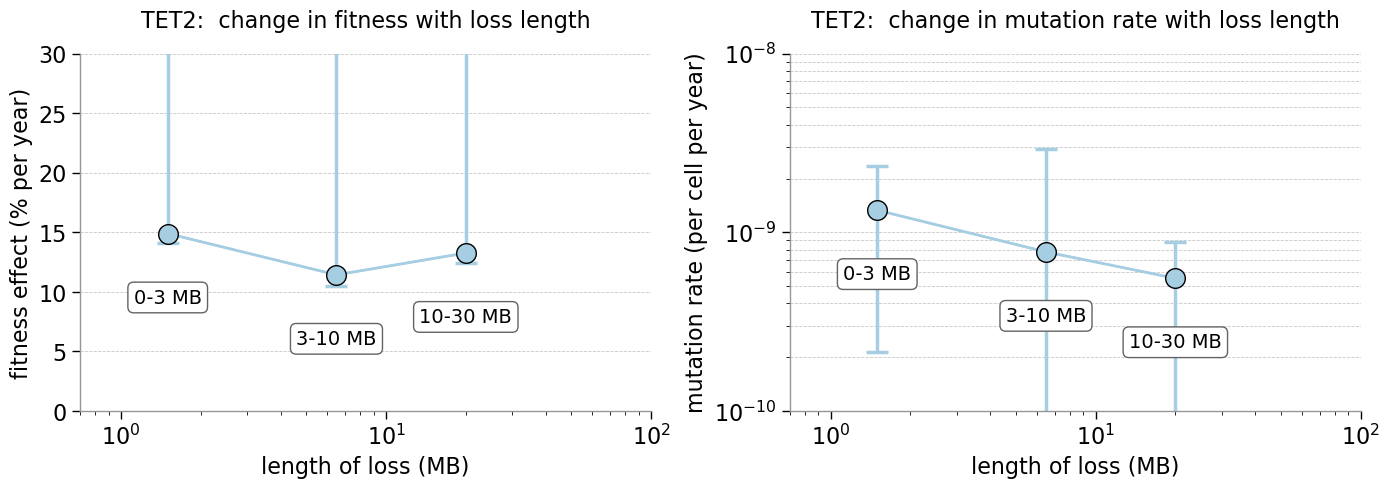

In [68]:
change_s_mu_length_plot('TET2', s_mu_length_dependence_dict, 0, 30, 1e-10, 1e-8)

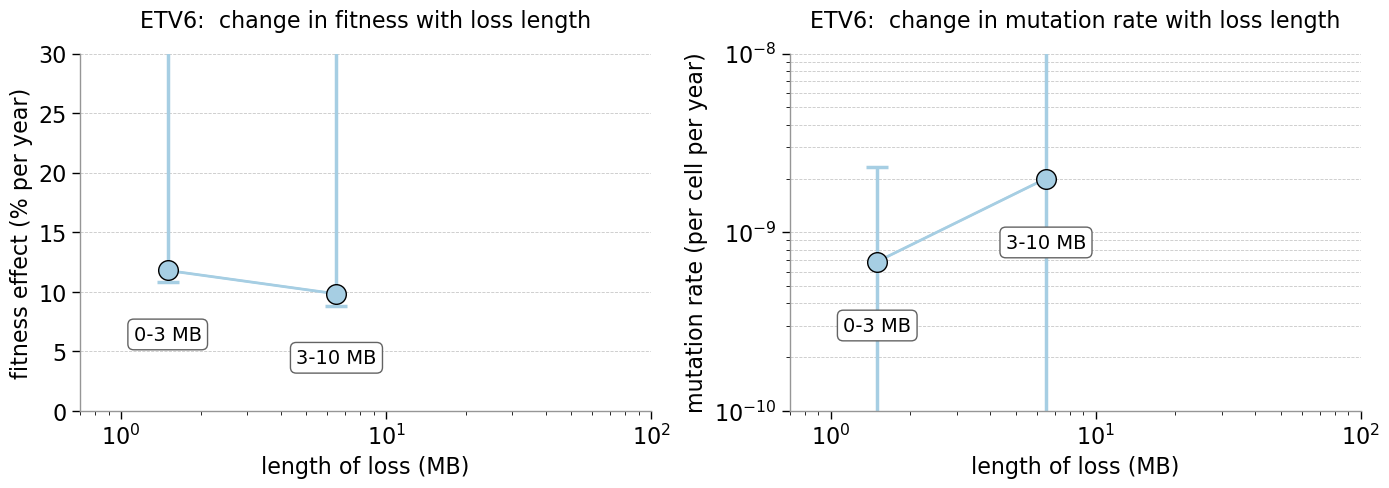

In [69]:
change_s_mu_length_plot('ETV6', s_mu_length_dependence_dict, 0, 30, 1e-10, 1e-8)

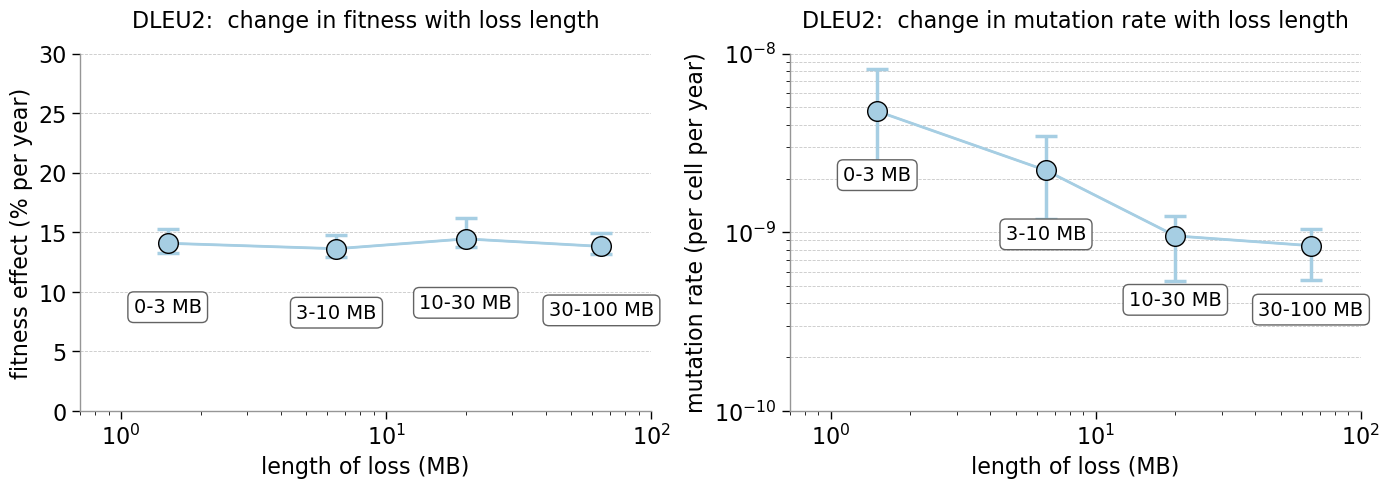

In [70]:
change_s_mu_length_plot('DLEU2', s_mu_length_dependence_dict, 0, 30, 1e-10, 1e-8)

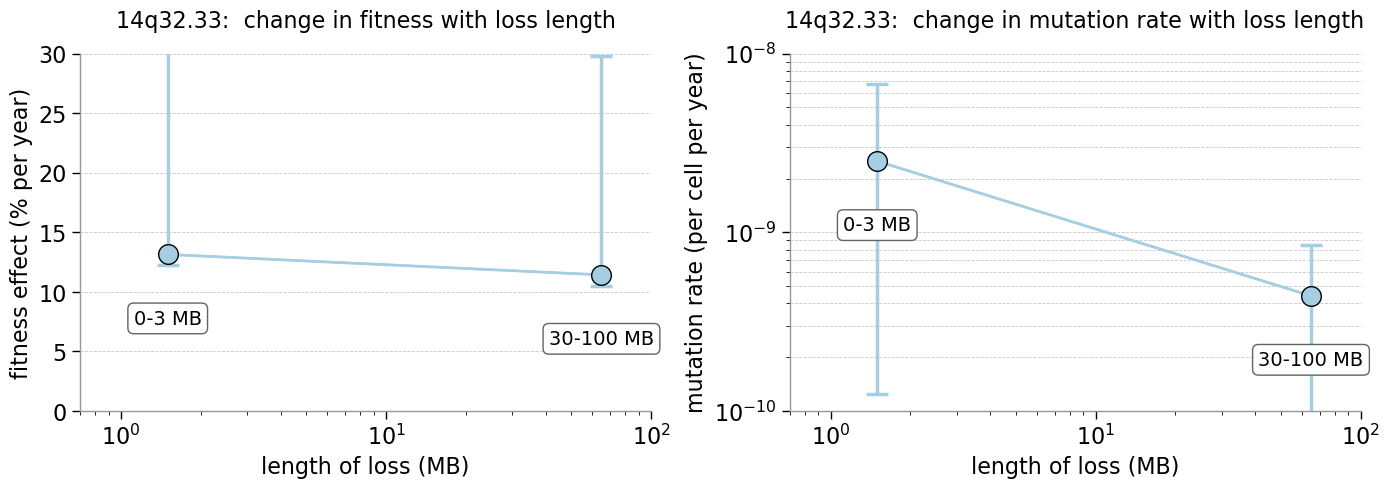

In [71]:
change_s_mu_length_plot('14q32.33', s_mu_length_dependence_dict, 0, 30, 1e-10, 1e-8)

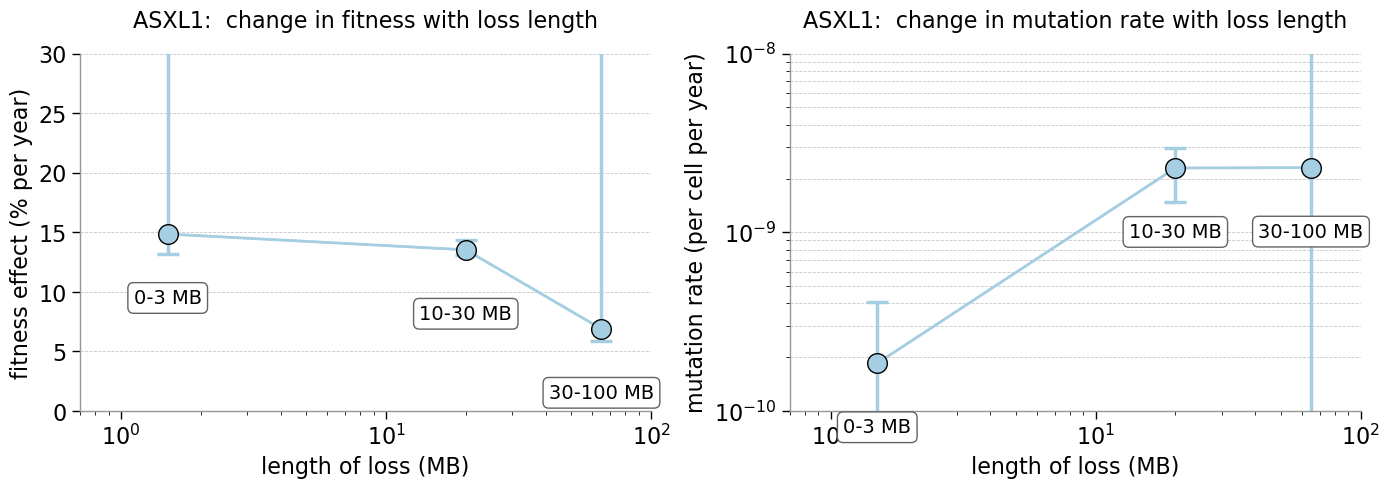

In [72]:
change_s_mu_length_plot('ASXL1', s_mu_length_dependence_dict, 0, 30, 1e-10, 1e-8)

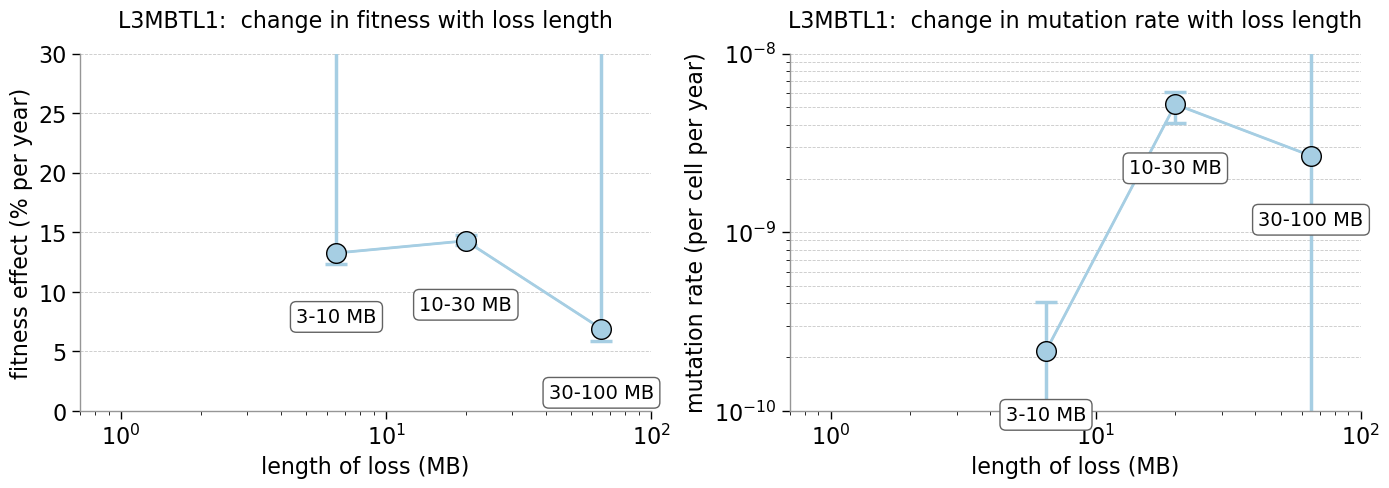

In [73]:
change_s_mu_length_plot('L3MBTL1', s_mu_length_dependence_dict, 0, 30, 1e-10, 1e-8)

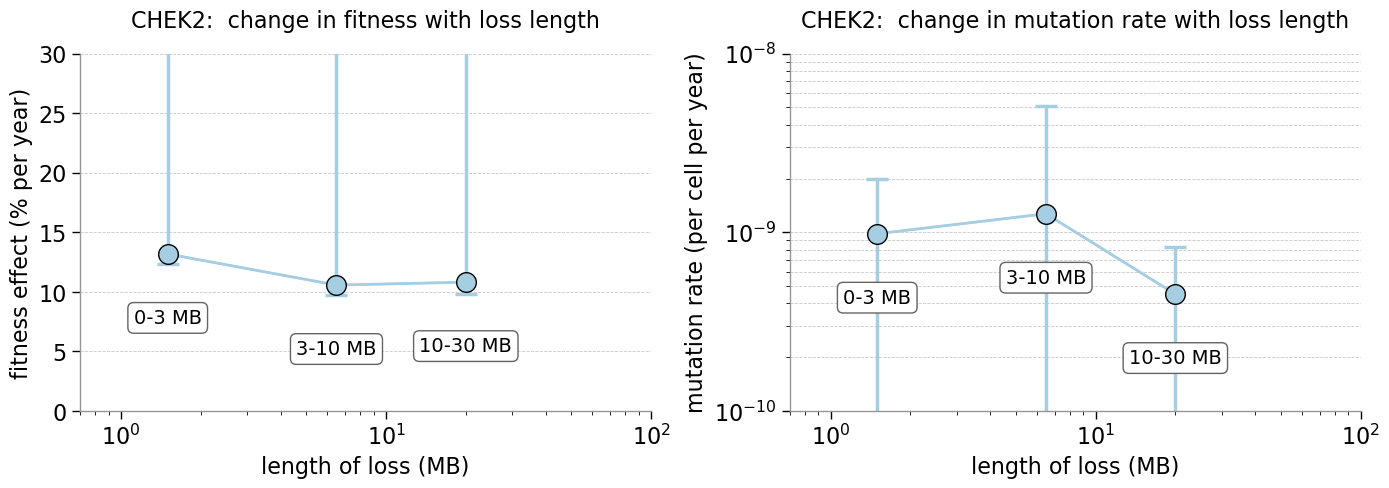

In [74]:
change_s_mu_length_plot('CHEK2', s_mu_length_dependence_dict, 0, 30, 1e-10, 1e-8)

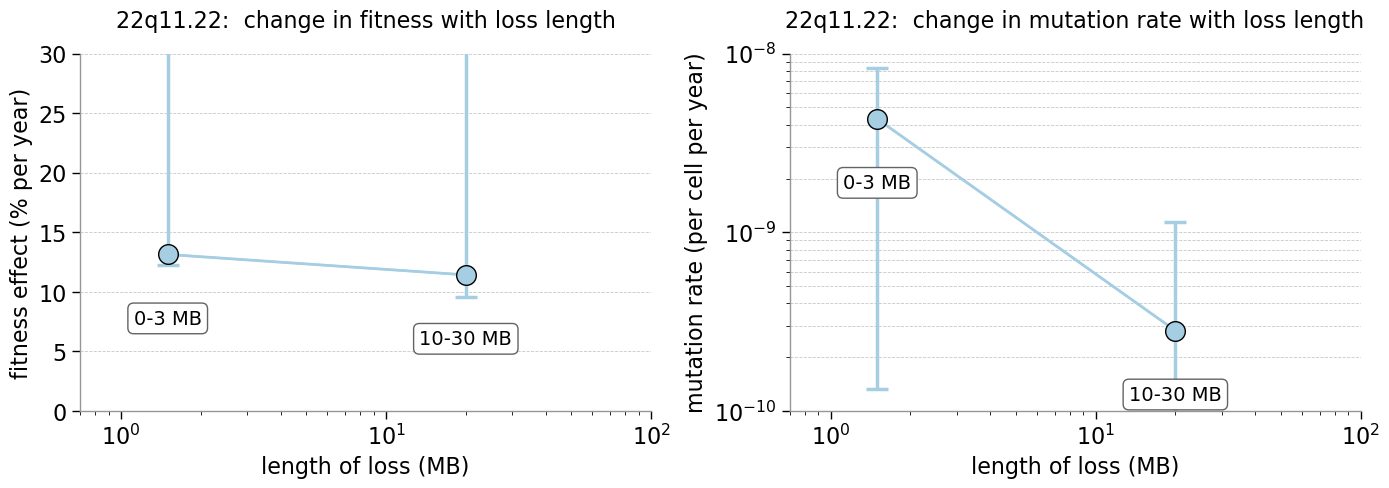

In [75]:
change_s_mu_length_plot('22q11.22', s_mu_length_dependence_dict, 0, 30, 1e-10, 1e-8)